# Constrained turbulence

This notebook contains a demonstration of how the `pyconturb` package can be easily used to generate turbulence that is constrained by one or more time series at a point in space.

The demo uses pre-generated time series that were simulated at a series of vertically spaced points. The `gen_turb` function is then used with these time series as constraints to result in a turbulence box that follows IEC 61400-1 Ed. 3 specifications but is correlated with the constraints. In other words, the coherence between the constraining time series and the simulated time series also follow IEC specifications.

It is worth noting that other models for the spectral magnitudes or coherences can be used. This demo is only meant as a proof-of-concept.


This example has the following sections:  

* [Preliminaries](#Preliminaries:-importing-functions)  

* [Constraining time series](#Constraining-time-series)  

* [Inputs to constrained turbulence](#Inputs-to-constrained-turbulence)  

* [Generate constrained turbulence](#Generate-constrained-turbulence)  

## Preliminaries: importing functions

We first set a few notebook-specific functions/variables and then import functions from the `pyconturb` package.

In [1]:
%matplotlib inline
from pathlib import Path

import matplotlib.pyplot as plt  # matplotlib for some plotting
import numpy as np  # numeric python functions
import pandas as pd  # need this to load our data from the csv files

from pyconturb import gen_turb, gen_spat_grid, TimeConstraint  # functions we need from PyConTurb

data_dir = Path('.').absolute() / 'data'

## Constraining time series

*Note: older versions of PyConTurb used con_spat_df and con_turb_df for constraints. This is deprecated and will not be supported in the future.*

The main object used when handling constraints is PyConTurb's `TimeConstraint` object. This object is basically the same as a pandas DataFrame but with a few extra features added. Please see the related section in the Reference guide for more info.

The constraining time series are stored in a CSV file. We can use pandas to load the data, though we need to do some cleaning on the index by converting the data types of some rows to floats.

In [2]:
con_tc = TimeConstraint(pd.read_csv(data_dir / 'con_tc.csv', index_col=0))  # load data from csv directly into tc
con_tc.index = con_tc.index.map(lambda x: float(x) if (x not in 'kxyz') else x)  # index cleaning
con_tc.iloc[:7, :]  # look at the first 7 rows

,u_p0,u_p1,u_p2,u_p3,u_p4,u_p5,v_p0,v_p1,v_p2,v_p3,v_p4,v_p5,w_p0,w_p1,w_p2,w_p3,w_p4,w_p5
index,,,,,,,,,,,,,,,,,,
k,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
x,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
y,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
z,15.000000,31.000000,50.000000,85.000000,110.000000,131.000000,15.000000,31.000000,50.000000,85.000000,110.000000,131.000000,15.000000,31.000000,50.000000,85.000000,110.000000,131.000000
0.0,10.150452,9.434762,11.832569,9.484165,9.770953,10.493375,-0.430319,1.158134,-2.263208,2.070390,-0.430243,-1.498706,0.730676,-0.875914,-0.218713,-1.324753,0.310156,0.130720
0.5,10.475959,10.167473,12.190913,10.061058,8.273560,11.658179,-1.648070,-0.735037,-2.015695,1.883539,-0.999865,-1.230614,-0.323829,-1.506976,-0.078518,-0.818285,0.995609,0.300717
1.0,9.983335,10.759020,11.971997,10.166726,8.503804,12.863211,0.977524,-1.373456,0.074650,2.233633,-1.589460,-1.033165,-0.288602,-2.034096,0.639279,-1.643624,0.233476,0.878348


We can see that the first 4 rows specify the turbulent component, longitudinal, lateral and vertical directions. Afterwards, the time step values come, which are the actual constraining values used in PyConTurb. This is the row order that PyConTurb requires/assumes.

**Note**: when generating constrained turbulence, the time step values in the `TimeConstraint` must be the same as the desired simulated turbulence (i.e., $T$, $\Delta t$). PyConTurb will raise an error if they do not match. This means you might need to interpolate/resample your constraints if you want to simulate a turbulence box with a certain $\Delta t$.

We can easily isolate just the spatial part or time part if needed.

In [3]:
con_tc.get_spat()

,u_p0,u_p1,u_p2,u_p3,u_p4,u_p5,v_p0,v_p1,v_p2,v_p3,v_p4,v_p5,w_p0,w_p1,w_p2,w_p3,w_p4,w_p5
index,,,,,,,,,,,,,,,,,,
k,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
z,15.0,31.0,50.0,85.0,110.0,131.0,15.0,31.0,50.0,85.0,110.0,131.0,15.0,31.0,50.0,85.0,110.0,131.0


In [4]:
con_tc.get_time().iloc[:5, :8]

,u_p0,u_p1,u_p2,u_p3,u_p4,u_p5,v_p0,v_p1
index,,,,,,,,
0.0,10.150452,9.434762,11.832569,9.484165,9.770953,10.493375,-0.430319,1.158134
0.5,10.475959,10.167473,12.190913,10.061058,8.273560,11.658179,-1.648070,-0.735037
1.0,9.983335,10.759020,11.971997,10.166726,8.503804,12.863211,0.977524,-1.373456
1.5,10.047177,13.313312,10.030070,10.861709,9.786593,12.904878,0.593077,-1.152047
2.0,10.890584,13.234037,12.169473,11.615199,10.128994,12.915150,0.820170,-0.918247


We can plot the points to visualize the locations of the constrainting points in space.

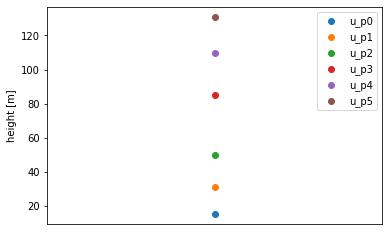

In [5]:
u_locs = con_tc.get_spat().filter(regex='u_').loc[['y', 'z']]
[plt.scatter(u_locs.loc['y', col], u_locs.loc['z', col], label=col)
 for col in u_locs];
plt.legend(); plt.ylabel('height [m]'); plt.xticks([]);

It is apparant that the constraining time series are located at a series of vertical heights, exactly as we would have if we were using data from 3D sonic anemometers on a met mast. Additionally, the numbering goes from `p0` at the lowest height to `p5` at the highest.

Now let's visualize the constraining time series.

7.348499074383097
8.496747859173015
9.349198761484706
10.395949882075524
10.946087842231579
11.335342608555468


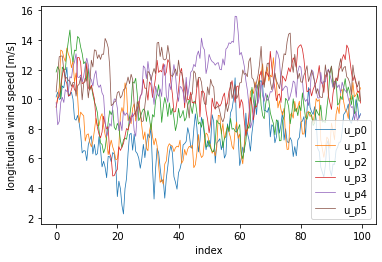

In [6]:
time_df = con_tc.get_time()
ax = time_df.filter(regex='u_', axis=1).plot(lw=0.75)  # subselect long. wind component
ax.set_ylabel('longitudinal wind speed [m/s]');
[print(x) for x in time_df.filter(regex='u_', axis=1).mean()];  # print mean values

We can see an increase in the mean wind speed for higher points, which is as expected.

Now, let's simulate a turbulence box.

## Inputs to constrained turbulence

The first step is to define the spatial information for the desired turbulence box and the related parameters for the turbulence generation technique. In this case we will use the default IEC 61400-1 Ed. 3 simulation procedures (Kaimal Spectrum with Exponential Coherence) instead of interpolating from the data. Note that, by default, PyConTurb will not interpolate profiles from data.

In [7]:
y = np.linspace(-65, 65, 5)  # lateral components of turbulent grid
z = np.linspace(14, 134, 9)  # vertical components of turbulent grid
kwargs = {'u_ref': 10, 'turb_class': 'B', 'z_hub': 70,  # necessary keyword arguments for IEC turbulence
          'T': con_tc.get_T(), 'nt': con_tc.get_time().size}  # simulation length (s) and time step (s)
interp_data = 'none'  # use the default IEC 61400-1 profile instead of interpolating from contstraints

This function below generates the actual spatial data. It assumes we want all three turbulence components at each spatial location.

In [9]:
spat_df = gen_spat_grid(y, z)  # create our spatial pandas dataframe. Columns are k, p_id x, y, and z.

A visualization of the simulation grid and constraining points:

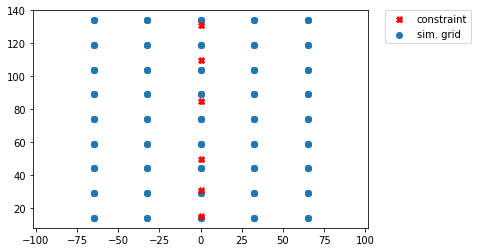

In [10]:
plt.scatter(spat_df.loc['y'], spat_df.loc['z'], label='sim. grid')
plt.plot(con_tc.iloc[2, :6], con_tc.iloc[3, :6], 'rX', label='constraint')
plt.axis('equal'); plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Generate constrained turbulence

We now pass our constraint object and other arguments into `gen_turb` as follows.

In [11]:
sim_turb_df = gen_turb(spat_df, con_tc=con_tc, interp_data=interp_data, **kwargs)

ValueError: operands could not be broadcast together with shapes (200,) (3600,) 

As a sanity check, let's compare a simulated point that is close to a constraint point. If we did this right, they should look similar to each other.

In [ ]:
# find the points close to where we want to look
yloc, zloc = 0, 14  # location we want to compare
isim = np.argmin((spat_df.loc['y'].values - yloc)**2+(spat_df.loc['z'].values - zloc)**2)
icon = np.argmin((con_tc.loc['y'].values - yloc)**2+(con_tc.loc['z'].values - zloc)**2)
t, usim, ucon = sim_turb_df.index, sim_turb_df.iloc[:, isim], con_tc.get_time().iloc[:, icon]
# plot the time series
plt.plot(t, usim, label='simulated')
plt.plot(t, ucon, 'r', label='constraint')
plt.legend();

Let's also check out statistics of $u$ by height:

In [ ]:
stats = sim_turb_df.filter(regex='u_', axis=1).describe().loc[['mean', 'std']]
# plot
plt.clf(); plt.subplot(1, 2, 1);
plt.scatter(stats.loc['mean'], spat_df.filter(regex='u_').loc['z'], label='Mean profile')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(stats.loc['std'], spat_df.filter(regex='u_').loc['z'], label='Std dev')
plt.legend();

**Note**: The profile functions selected for the wind speed, turbulence standard deviation and power spectra affect whether you regenerate the constraining data if a simulation point is collocated. One option is to use the built-in profile functions that interpolates these profiles from your data (see related example in the documentation). Otherwise, you can define your own profile functions for custom interpolation.